In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/../src/simulations_v2")
    sys.path.append(module_path + "/..")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *

In [3]:
def load_sim_output(sim_output_files):
    scenario_data = pd.DataFrame(columns=UNCERTAINTY_PARAMS_LIST+\
            ['res_tests_per_day', 'res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10',
                'res_ithaca_inf_50','res_ithaca_inf_90'])

    for fname in sim_output_files:
        with open(fname, 'rb') as fhandle:
            [uncertainty_point, res_tests_per_day, res_inf_matrix, res_hosp_matrix] = dill.load(fhandle)

        new_row = dict()
        for index, col_name in enumerate(UNCERTAINTY_PARAMS_LIST):
            if type(uncertainty_point) == dict:
                new_row[col_name] = uncertainty_point[col_name]
            else:
                new_row[col_name] = uncertainty_point[index]
                
        new_row['res_tests_per_day'] = res_tests_per_day

        res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
        new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
        new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
        new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
        new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
        new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
        new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

        scenario_data = scenario_data.append(new_row, ignore_index=True)
    return scenario_data

In [4]:
centre_sim_files = []
for i in range(10):
    fname = '/home/aaj54/group-testing/notebooks/pnas_paper_figs/test_pareto_centre_1622010686/point_{}.dill'.format(i)
    centre_sim_files.append(fname)

pess_sim_files = []
for i in range(10):
    fname = '/home/aaj54/group-testing/notebooks/pnas_paper_figs/test_pareto_pess_1622010686/point_{}.dill'.format(i)
    pess_sim_files.append(fname)
    
centre_data = load_sim_output(centre_sim_files)
pess_data = load_sim_output(pess_sim_files)
centre_data, pess_data

(   asymp_prob_mult  inital_prev_mult   R0  outside_inf_mult  \
 0              1.0               1.0  2.5               1.0   
 1              1.0               1.0  2.5               1.0   
 2              1.0               1.0  2.5               1.0   
 3              1.0               1.0  2.5               1.0   
 4              1.0               1.0  2.5               1.0   
 5              1.0               1.0  2.5               1.0   
 6              1.0               1.0  2.5               1.0   
 7              1.0               1.0  2.5               1.0   
 8              1.0               1.0  2.5               1.0   
 9              1.0               1.0  2.5               1.0   
 
    daily_self_report_prob  ct_mult  ct_testing_ratio  test_sensitivity  \
 0                    0.36      1.5               1.0               0.6   
 1                    0.36      1.5               1.0               0.6   
 2                    0.36      1.5               1.0               0

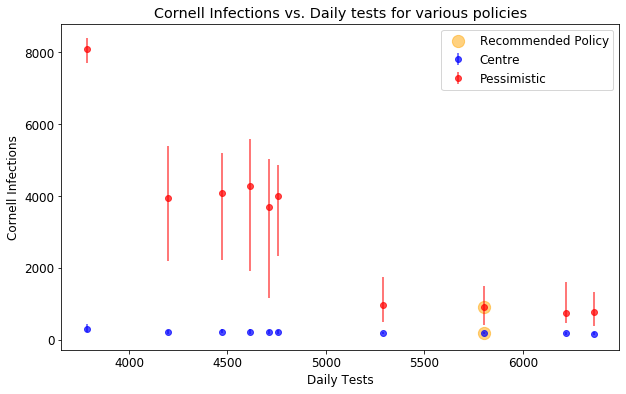

In [20]:
selected_policy_index = 3

f, axs = plt.subplots(1,1,sharex=True,figsize=(10,6))

plt.subplot(1,1,1)
plt.errorbar(x='res_tests_per_day', y='res_cornell_inf_50', yerr = [centre_data['res_cornell_inf_50'] - centre_data['res_cornell_inf_10'],centre_data['res_cornell_inf_90'] - centre_data['res_cornell_inf_50']], fmt='o', data=centre_data, label='Centre', c='blue', alpha=0.7)
plt.scatter(x=centre_data['res_tests_per_day'][selected_policy_index], y=centre_data['res_cornell_inf_50'][selected_policy_index],c='orange',s=150,alpha=0.5, label='Recommended Policy')

plt.errorbar(x='res_tests_per_day', y='res_cornell_inf_50', yerr = [pess_data['res_cornell_inf_50'] - pess_data['res_cornell_inf_10'], pess_data['res_cornell_inf_90'] - pess_data['res_cornell_inf_50']], fmt='o', data=pess_data, label='Pessimistic', c='red', alpha=0.7)
plt.scatter(x=pess_data['res_tests_per_day'][selected_policy_index], y=pess_data['res_cornell_inf_50'][selected_policy_index],c='orange',s=150,alpha=0.5)

# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.legend()
# plt.ylim([0,6000])

plt.show()

# plt.savefig('res_inst_paper_graphs/mar_19_graphs/testing_policies_pareto.png', dpi=450)